In [ ]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

In [ ]:
def create_clients(image_list, label_list, num_clients=10, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as
                data shards - tuple of images and label lists.
        args:
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1

    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))}



def batch_data(data_shard, bs=32):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)


class SimpleMLP:
    @staticmethod
    def build(shape, classes):
        model = Sequential()
        model.add(Dense(200, input_shape=(shape,)))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        return model


def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)

    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
!git clone "https://github.com/krupallad09/Traffic_Sign_Recognition.git"

Cloning into 'Traffic_Sign_Recognition'...
remote: Enumerating objects: 103901, done.
remote: Counting objects: 100% (12647/12647), done.
remote: Compressing objects: 100% (12591/12591), done.
remote: Total 103901 (delta 60), reused 12642 (delta 55), pack-reused 91254
Receiving objects: 100% (103901/103901), 641.15 MiB | 22.44 MiB/s, done.
Resolving deltas: 100% (187/187), done.
Updating files: 100% (51885/51885), done.


In [ ]:
! wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv -P /content/Traffic_Sign_Recognition

--2024-04-22 08:46:28--  https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 999 [text/plain]
Saving to: ‘/content/Traffic_Sign_Recognition/signnames.csv’

signnames.csv       100%[===================>]     999  --.-KB/s    in 0s      

2024-04-22 08:46:28 (62.5 MB/s) - ‘/content/Traffic_Sign_Recognition/signnames.csv’ saved [999/999]



In [ ]:
!pwd

/content


In [ ]:
import pandas as pd
classes = pd.read_csv('/content/Traffic_Sign_Recognition/signnames.csv')
class_names = {}
for i, row in classes.iterrows():
    class_names[str(row[0])] = row[1]
print(class_names)
print(type(class_names))
print(class_names.get(0))

{'0': 'Speed limit (20km/h)', '1': 'Speed limit (30km/h)', '2': 'Speed limit (50km/h)', '3': 'Speed limit (60km/h)', '4': 'Speed limit (70km/h)', '5': 'Speed limit (80km/h)', '6': 'End of speed limit (80km/h)', '7': 'Speed limit (100km/h)', '8': 'Speed limit (120km/h)', '9': 'No passing', '10': 'No passing for vechiles over 3.5 metric tons', '11': 'Right-of-way at the next intersection', '12': 'Priority road', '13': 'Yield', '14': 'Stop', '15': 'No vechiles', '16': 'Vechiles over 3.5 metric tons prohibited', '17': 'No entry', '18': 'General caution', '19': 'Dangerous curve to the left', '20': 'Dangerous curve to the right', '21': 'Double curve', '22': 'Bumpy road', '23': 'Slippery road', '24': 'Road narrows on the right', '25': 'Road work', '26': 'Traffic signals', '27': 'Pedestrians', '28': 'Children crossing', '29': 'Bicycles crossing', '30': 'Beware of ice/snow', '31': 'Wild animals crossing', '32': 'End of all speed and passing limits', '33': 'Turn right ahead', '34': 'Turn left ah

In [ ]:
def load(paths, verbose=-1, desired_width = 50, desired_height = 50):
    '''expects images for each class in seperate dir,
    e.g all digits in 0 class in the directory named 0 '''
    print(paths)
    data = list()
    labels = list()
    # loop over the input images
    for (i, imgpath) in enumerate(paths):
        # load the image and extract the class labels
        im_gray = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
        resized_image = cv2.resize(im_gray, (desired_width, desired_height))

        image = np.array(resized_image).flatten()
        label = imgpath.split(os.path.sep)[-2]
        x = str(int(label))
        class_name = class_names.get(x)
        # scale the image to [0, 1] and add to list
        data.append(image/255)
        labels.append(class_name)
        # show an update every `verbose` images
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] processed {}/{}".format(i + 1, len(paths)))
    # return a tuple of the data and labels
    return data, labels

In [ ]:
directory_path = '/content/Traffic_Sign_Recognition/GTSRB/Final_Training/Images'
ppm_files = []
for root, dirs, files in os.walk(directory_path):
    for file in files:
        if file.endswith('.ppm'):
            ppm_file_path = os.path.join(root, file)
            ppm_files.append(ppm_file_path)
ppm_files.sort()
print(ppm_files[0])

/content/Traffic_Sign_Recognition/GTSRB/Final_Training/Images/00000/00000_00000.ppm


In [ ]:
image_list, label_list = load(ppm_files, verbose=10000)
lb = LabelBinarizer()
label_list = lb.fit_transform(label_list)

X_train, X_test, y_train, y_test = train_test_split(image_list,
                                                    label_list,
                                                    test_size=0.1,
                                                    random_state=42)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO] processed 10000/39209
[INFO] processed 20000/39209
[INFO] processed 30000/39209


In [ ]:
# prompt: print max size of X_trian all items
max_size = print(max([len(i) for i in X_train]))
min_size = print(min([len(i) for i in X_train]))

2500
2500


In [ ]:
def create_clients(image_list, label_list, num_clients=10, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as
                data shards - tuple of images and label lists.
        args:
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1

    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))}

In [ ]:
clients = create_clients(X_train, y_train, num_clients=10, initial='client')

In [ ]:
def batch_data(data_shard, bs=32):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)

In [ ]:
#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)

#process and batch the test set
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

In [ ]:
class SimpleMLP:
    @staticmethod
    def build(shape, classes):
        model = Sequential()
        model.add(Dense(200, input_shape=(shape,)))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        return model

In [ ]:

lr = 0.01
comms_round = 100
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = tf.keras.optimizers.legacy.SGD(lr=lr,
                decay=lr / comms_round,
                momentum=0.9
               )

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)

    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [ ]:
#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(2500, 43)

global_acc_arr = []
global_loss_arr = []
#commence global training loop
for comm_round in range(comms_round):

    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()

    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)

    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(2500, 43)
        local_model.compile(loss=loss,
                      optimizer=optimizer,
                      metrics=metrics)

        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)

        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=1, verbose=0)

        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)

        #clear session to free memory after each communication round
        K.clear_session()

    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)

    #update global model
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        global_acc_arr.append(global_acc * 100)
        global_loss_arr.append(global_loss.numpy())


123/123 [==============================] - 0s 2ms/step
comm_round: 0 | global_acc: 13.517% | global_loss: 3.7444443702697754
123/123 [==============================] - 0s 2ms/step
comm_round: 1 | global_acc: 19.255% | global_loss: 3.7364754676818848
123/123 [==============================] - 0s 1ms/step
comm_round: 2 | global_acc: 23.897% | global_loss: 3.725757598876953
123/123 [==============================] - 0s 1ms/step
comm_round: 3 | global_acc: 27.927% | global_loss: 3.712834358215332
123/123 [==============================] - 0s 1ms/step
comm_round: 4 | global_acc: 33.435% | global_loss: 3.694923162460327
123/123 [==============================] - 0s 2ms/step
comm_round: 5 | global_acc: 37.184% | global_loss: 3.6773924827575684
123/123 [==============================] - 0s 2ms/step
comm_round: 6 | global_acc: 39.123% | global_loss: 3.656308889389038
123/123 [==============================] - 0s 1ms/step
comm_round: 7 | global_acc: 41.928% | global_loss: 3.6345176696777344
123/

In [ ]:
import matplotlib.pyplot as plt


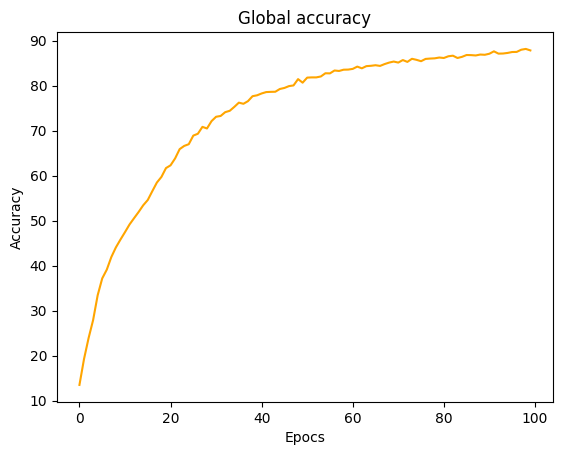

In [ ]:
plt.title("Global accuracy")
plt.xlabel("Epocs")
plt.ylabel("Accuracy")
x = np.arange(0, 100)
plt.plot(x, global_acc_arr, color ="orange")
plt.show()

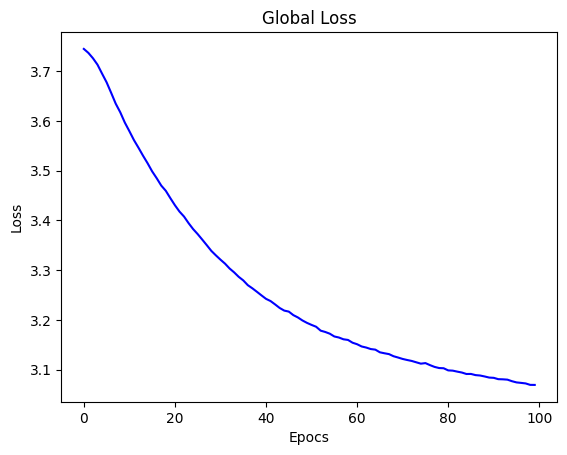

In [ ]:
plt.title("Global Loss")
plt.xlabel("Epocs")
plt.ylabel("Loss")
x = np.arange(0, 100)
plt.plot(x, global_loss_arr, color ="blue")
plt.show()